In [22]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

### Работаем над датасетом, содержащем информацию об объявлениях на Airbnb в Лондоне 🇬🇧

In [2]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

#### Проверяем подключение простым запросом

In [5]:
query = '''
SELECT COUNT(*)
FROM ldn_listings
'''

df = ph.read_clickhouse(query, connection=connection)
df

,count()
0,85207


#### Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

- price – цена за ночь
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

In [6]:
query2 = """
SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type
    
FROM ldn_listings  


ORDER BY 
    id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query2, connection=connection)
df.head()

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt


#### Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

In [25]:
df.groupby('room_type', as_index=False) \
    .quantile(q=0.75) \
    .query('room_type == "Private room"')

,room_type,price
2,Private room,70.0


#### К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating).

In [12]:
query3 = """
SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
    
FROM ldn_listings  

WHERE review_scores_rating != 0

ORDER BY 
    id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query3, connection=connection)
df.head()

,price,room_type,review_scores_rating
0,65.0,Private room,97.0
1,100.0,Entire home/apt,96.0
2,300.0,Entire home/apt,94.0
3,65.0,Entire home/apt,93.0
4,29.0,Private room,96.0


#### Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [14]:
df = df.groupby('room_type', as_index=False) \
    .agg({'price': 'mean', 'review_scores_rating': 'mean'})

df = df.rename(columns={'price': 'avg_price', 'review_scores_rating': 'avg_review_scores_rating'})
df

,room_type,avg_price,avg_review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


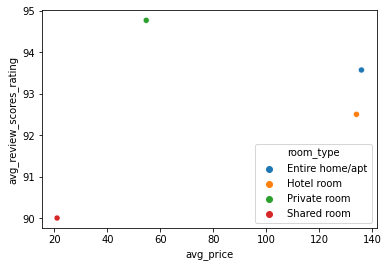

In [15]:
sns.scatterplot(x = 'avg_price', y = 'avg_review_scores_rating', hue = 'room_type', data = df)

#### Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

#### Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered). Для каждого уникального пользователя выгрузите только две колонки:

#### host_id – идентификатор хозяина (уникальный) host_verifications – какими способами хост подтвердил свой профиль Затем обработайте столбец host_verifications:

#### В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта:

In [16]:
query4 = """
SELECT 
    DISTINCT(host_id) as host_id,
    host_verifications
FROM ldn_listings  

WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query4, connection=connection)
df.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


#### Далее посмотрим сколько раз встречается каждый из способов верификации

In [17]:
df['host_verifications'] = df.host_verifications.apply(lambda x: x.strip('[]').replace(',', '').split(sep=' '))
df.host_verifications.explode().value_counts()

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

#### Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count

In [18]:
query5 = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    count(*) AS experiences_count 
FROM ldn_listings  

WHERE experiences_offered != 'none'

GROUP BY  
    neighbourhood_cleansed,
    experiences_offered
    
ORDER BY  
    experiences_count DESC
    
LIMIT 100
"""
df = ph.read_clickhouse(query5, connection=connection)
df.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


#### Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap()

In [19]:
df = df.pivot(columns = 'experiences_offered', values = 'experiences_count', index = 'neighbourhood_cleansed')
df

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


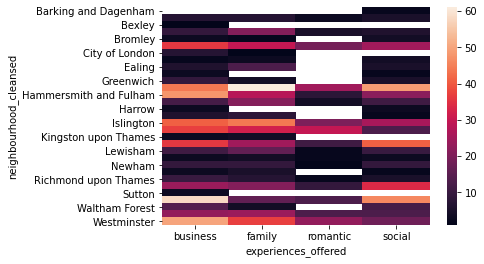

In [20]:
cmap=sns.cubehelix_palette(as_cmap=True)
sns.heatmap(data = df)

#### Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь 
- experiences_offered – вид доступного впечатления (оставить не 'none')

In [21]:
query6 = """
SELECT 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    room_type
    
FROM ldn_listings  

WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query6, connection = connection)
df.head()

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,150.0,Private room
3,45.0,Private room
4,25.0,Private room


In [23]:
df.room_type.value_counts()

Entire home/apt    922
Private room       613
Shared room          9
Hotel room           4
Name: room_type, dtype: int64

#### Постройте график распределения цен для каждого типа жилья

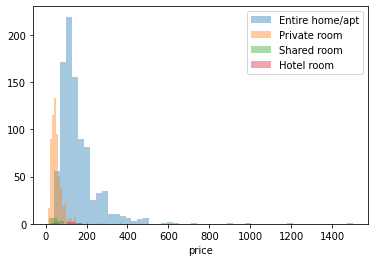

In [26]:
sns.distplot(df.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type == 'Private room'").price, kde=False, label='Private room')
sns.distplot(df.query("room_type == 'Shared room'").price, kde=False, label='Shared room')
sns.distplot(df.query("room_type == 'Hotel room'").price, kde=False, label='Hotel room')
plt.legend()
plt.show()

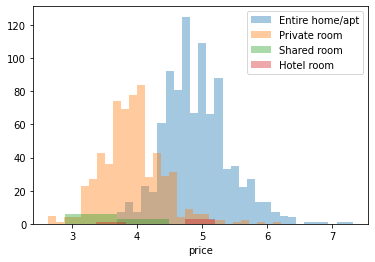

In [25]:
sns.distplot(np.log(df.query("room_type == 'Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type == 'Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type == 'Shared room'").price), kde=False, label='Shared room')
sns.distplot(np.log(df.query("room_type == 'Hotel room'").price), kde=False, label='Hotel room')
plt.legend()
plt.show()

#### Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь
- first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

In [37]:
query7 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
    
FROM ldn_listings  

WHERE first_review > '2010-01-01'
    
LIMIT 1000
"""
df = ph.read_clickhouse(query7, connection=connection)
df.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


#### Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье в зависимости от типа комнаты по годам. Датафрейм должен быть отсортирован по годам.

In [38]:
df['first_review'] = df.first_review.apply(lambda x: x[:-6])
df = df.sort_values('first_review')

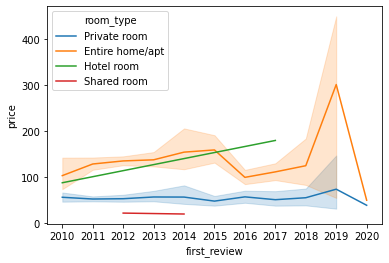

In [39]:
sns.lineplot(x = 'first_review', y = 'price', hue = 'room_type', data = df)